In [278]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [530]:
from matplotlib import pyplot as plt
import numpy as np
from copy import deepcopy
import torch
from uncertaintylearning.utils import (FixedKernelDensityEstimator, CVKernelDensityEstimator,
                                       create_network, create_optimizer, create_multiplicative_scheduler)
from uncertaintylearning.utils.density_estimator import GPVarianceEstimator
from uncertaintylearning.utils.feature_generator import FeatureGenerator
from uncertaintylearning.utils.buffer import Buffer
from uncertaintylearning.models import EpistemicPredictor, MCDropout
from torch.utils.data import DataLoader, TensorDataset


In [659]:
def oracle(x, noise=0.):
    # returns sin(2pi x) + epsilon with epsilon ~ N(0, 0.1)
    with torch.no_grad():
        m = torch.distributions.Normal(torch.tensor([0.0]), torch.tensor([1]))
        m = m.sample((x.size(0),))
        return (2 * np.pi * x).sin() + noise * m

def generate_data(n=1024, sep=1):
    # generate data from U([0, 1/2] union U([1/2 + sep, 1 + sep]))
    # sep needs to be < 1.5
    with torch.no_grad():
        x = torch.zeros(n // 2, 1).uniform_(0, 0.5)
        x = torch.cat((x, torch.zeros(n // 2, 1).uniform_(1.5, 2)), 0)
        # x = torch.zeros(n, 1).uniform_(0, 2)
        x_test = torch.linspace(-3, 5, 1024).view(-1, 1)
        ood_x = torch.FloatTensor(20, 1).uniform_(0.5, 1.5)
        ood_x = torch.cat((ood_x, torch.FloatTensor(20, 1).uniform_(-2, 0)), 0)
        ood_x = torch.cat((ood_x, torch.FloatTensor(20, 1).uniform_(2, 4)), 0)
        y = oracle(x)
        y2 = oracle(x)
        ood_y = oracle(ood_x)
        y_test_true = oracle(x_test, noise=0)
        return x, y, y2, x_test, y_test_true, ood_x, ood_y

x, y, y2, x_test, y_test, ood_x, ood_y = generate_data(124)
X_train = torch.cat((x, ood_x))
Y_train = torch.cat((y, ood_y))
features = 'xvb'
buffer = Buffer(1, features=features)
len_ood = len(ood_x)

In [660]:
use_log_unc = False
use_variance_scaling = False


In [661]:
rand_perm = torch.randperm(len_ood)[:0]
xx = torch.cat((x, ood_x[rand_perm]))
yy = torch.cat((y, ood_y[rand_perm]))
varmodel = SingleTaskGP(xx, yy)
variance_estimator = GPVarianceEstimator(varmodel, loggify=False, use_variance_scaling=use_variance_scaling, domain=x_test)
variance_estimator.fit()
fg = FeatureGenerator(features, variance_estimator=variance_estimator, training_set=xx)
targets = (varmodel(X_train).mean.detach().unsqueeze(-1) - Y_train).pow(2)
features_lis = fg(X_train)
buffer.add_features(features_lis)
buffer.add_targets(targets)

In [628]:
# EITHER RUN THIS OR THE PREVIOUS ONE
for _ in range(5):
    rand_perm = torch.randperm(len_ood)[:5]
    xx = torch.cat((x, ood_x[rand_perm]))
    yy = torch.cat((y, ood_y[rand_perm]))
    varmodel = SingleTaskGP(xx, yy)
    variance_estimator = GPVarianceEstimator(varmodel, loggify=False, use_variance_scaling=use_variance_scaling, domain=x_test)
    variance_estimator.fit()
    fg = FeatureGenerator(features, variance_estimator=variance_estimator, training_set=xx)
    targets = (varmodel(X_train).mean.detach().unsqueeze(-1) - Y_train).pow(2)
    features_lis = fg(X_train)
    buffer.add_features(features_lis)
    buffer.add_targets(targets)

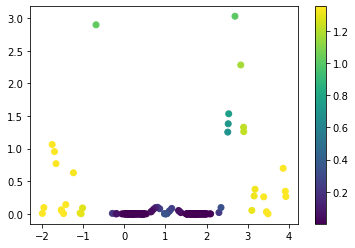

In [662]:
if features == 'xv' or features == 'xvb':

    plt.scatter(buffer.features[:, 0], buffer.targets, c=buffer.features[:, 1])
    plt.colorbar()

In [ ]:
plt.scatter(buffer.features[:, 0], buffer.targets)
plt.colorbar()

In [663]:
e = create_network(len(features), 1, 128, 'relu', not use_log_unc, 2)
o = create_optimizer(e, 1e-3)
ds = TensorDataset(buffer.features, buffer.targets)
dl = DataLoader(ds, batch_size=16)


In [664]:
epochs = 500
e_losses = []
for epoch in range(epochs):
    epoch_losses = []
    for batch_id, (features_i, target_i) in enumerate(dl):
        o.zero_grad()
        loss_hat = e(features_i)
        e_loss = torch.nn.MSELoss()(loss_hat, target_i)
        e_loss.backward()
        o.step()
        epoch_losses.append(e_loss.item())
    e_losses.append(np.mean(epoch_losses))

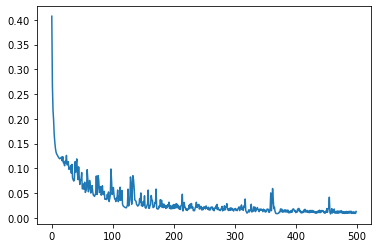

In [665]:
plt.plot(e_losses)

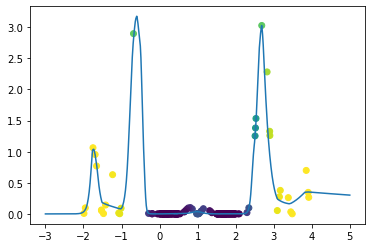

In [666]:
if features == 'xv' or features == 'xvb':
    plt.scatter(buffer.features[:, 0], buffer.targets, c=buffer.features[:, 1])
    plt.plot(x_test, e(fg(x_test)).detach())

In [651]:
if features == 'v':
    variances = torch.linspace(0, 1).unsqueeze(1)
    plt.scatter(buffer.features[:, 0], buffer.targets)
    plt.plot(variances, e(variances).detach())

## STEP 2

In [667]:
model = SingleTaskGP(X_train, Y_train)
mll = ExactMarginalLogLikelihood(model.likelihood, model)
_ = fit_gpytorch_model(mll)

In [668]:
new_varmodel = SingleTaskGP(X_train, Y_train)
new_variance_estimator = GPVarianceEstimator(new_varmodel, loggify=False, use_variance_scaling=use_variance_scaling, domain=x_test)
new_variance_estimator.fit()
new_fg = FeatureGenerator(features, variance_estimator=new_variance_estimator, training_set=X_train)

In [677]:
test_dataset = new_fg(x_test)

In [681]:
ground_truth_errors = (model(x_test).mean.detach() - y_test.squeeze()).pow(2)


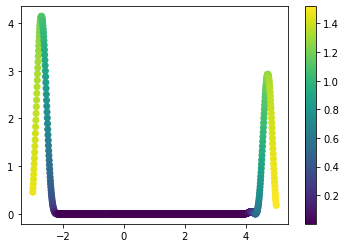

In [682]:
if features == 'xv' or features == 'xvb':

    plt.scatter(new_dataset[:, 0], ground_truth_errors, c=new_dataset[:, 1])
    plt.colorbar()

In [683]:
deup_stddev = e(new_fg(x_test)).sqrt().detach().squeeze()

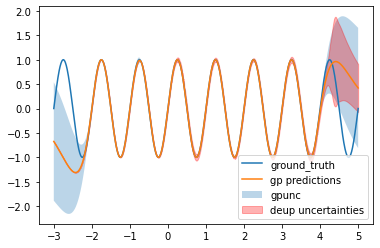

In [684]:
plt.plot(x_test, y_test, label='ground_truth')
plt.plot(x_test.squeeze(), model(x_test).mean.detach(), label='gp predictions')
plt.fill_between(x_test.squeeze(), model(x_test).mean.detach() - model(x_test).stddev.detach(),
                model(x_test).mean.detach() + model(x_test).stddev.detach(), alpha=.3, label='gpunc')
plt.fill_between(x_test.squeeze(), model(x_test).mean.detach() - deup_stddev,
                model(x_test).mean.detach() + deup_stddev, color='red', alpha=.3, label='deup uncertainties')
plt.legend()

In [685]:
ground_truth_errors

tensor([0.4551, 0.5378, 0.6273,  ..., 0.2858, 0.2283, 0.1772])

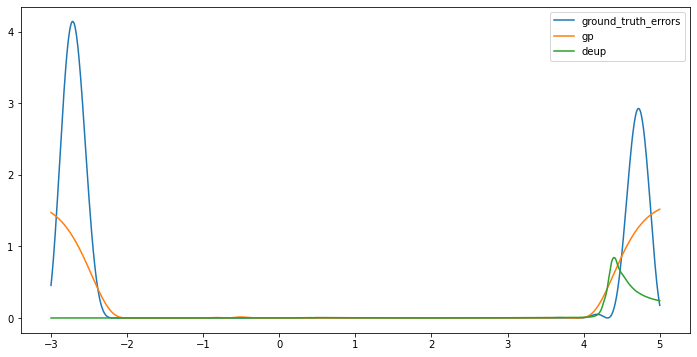

In [686]:
plt.figure(figsize=(12, 6))
gp_var = model(x_test).stddev.detach().pow(2)
plt.plot(x_test.squeeze(), ground_truth_errors.squeeze(), label='ground_truth_errors')
plt.plot(x_test.squeeze(), gp_var.squeeze(), label='gp')
plt.plot(x_test.squeeze(), deup_stddev.pow(2).squeeze(), label='deup')
plt.legend()

In [658]:
print('DEUP: ', (deup_stddev.pow(2) - ground_truth_errors).pow(2).mean())
print('GPvar: ', (gp_var - ground_truth_errors).pow(2).mean())

DEUP:  tensor(2.1298)
GPvar:  tensor(0.0866)


# OLD sutff (cheating version)

In [479]:
networks = {'a_predictor': create_network(1, 1, 64, 'tanh', True),
            'e_predictor': create_network(len(features), 1, 128, 'relu', True, 3),
            'f_predictor': create_network(1, 1, 64, 'relu', False)
            }

optimizers = {'a_optimizer': create_optimizer(networks['a_predictor'], 1e-2),
              'e_optimizer': create_optimizer(networks['e_predictor'], 1e-4),
              'f_optimizer': create_optimizer(networks['f_predictor'], 1e-3)
              }

In [477]:
gpmodel = SingleTaskGP(x, y)
varest = GPVarianceEstimator(gpmodel)
varest.fit()
fg = FeatureGenerator('xv', variance_estimator=varest)
model = EpistemicPredictor(x, y, fg, networks, optimizers)

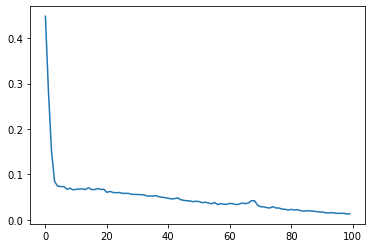

In [478]:
f_losses = model.fit(epochs=100)
plt.plot(f_losses)

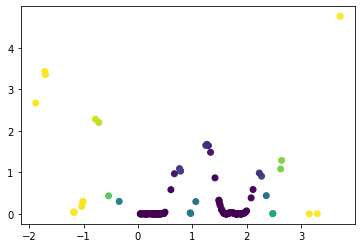

In [480]:
buffer = Buffer(1)
buffer.add_features(fg(X_train))
buffer.add_targets((model.f_predictor(X_train) - Y_train).pow(2).detach())
plt.scatter(buffer.features[:, 0], buffer.targets, c=buffer.features[:, 1])


In [481]:
e_losses = model.fit_uncertainty_estimator(buffer.features, buffer.targets, epochs=500)

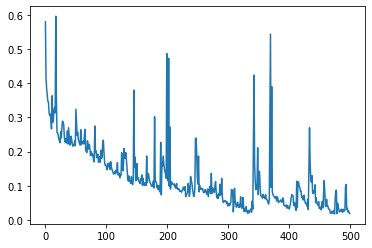

In [482]:
plt.plot(e_losses)

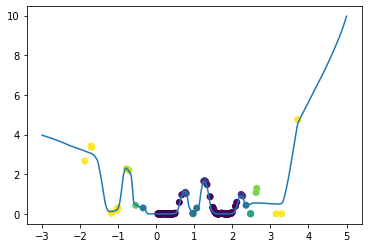

In [483]:
plt.scatter(buffer.features[:, 0], buffer.targets, c=buffer.features[:, 1])
plt.plot(x_test, model.e_predictor(fg(x_test)).detach())

In [484]:
true_L2_errors = (model.f_predictor(x_test) - y_test).pow(2).detach()

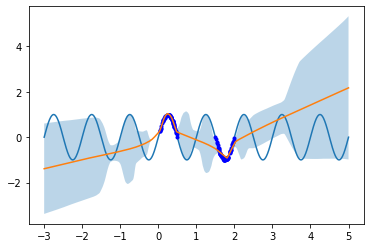

In [485]:
plt.plot(x_test, y_test, label='ground_truth')
plt.plot(x, y, 'b.', label='train')
predictions = model(x_test)
plt.plot(x_test, predictions.mean.detach(), label='predicted')
plt.fill_between(x_test.squeeze(), predictions.mean.detach() - predictions.stddev.detach(),
                 predictions.mean.detach() + predictions.stddev.detach(), alpha=.3, label='predicted stddev')

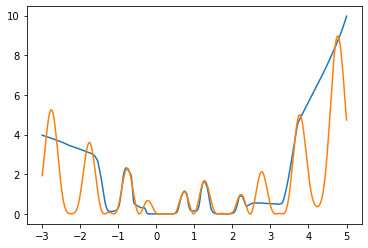

In [486]:
plt.plot(x_test, model._uncertainty(x=x_test).detach())
plt.plot(x_test, true_L2_errors, label='true')

In [111]:
from botorch.models import SingleTaskGP
from sklearn.linear_model import LinearRegression
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.fit import fit_gpytorch_model

In [487]:

gpmodel = SingleTaskGP(x, y)

In [488]:
mll = ExactMarginalLogLikelihood(gpmodel.likelihood, gpmodel)
_ =fit_gpytorch_model(mll)

In [489]:
gp_predictions = gpmodel(x_test)

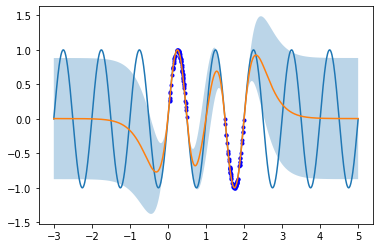

In [490]:
plt.plot(x_test, y_test, label='ground_truth')
plt.plot(x, y, 'b.', label='train')
plt.plot(x_test, gp_predictions.mean.detach(), label='predicted')
plt.fill_between(x_test.squeeze(), gp_predictions.mean.detach() - gp_predictions.stddev.detach(),
                 gp_predictions.mean.detach() + gp_predictions.stddev.detach(), alpha=.3, label='predicted GP stddev')

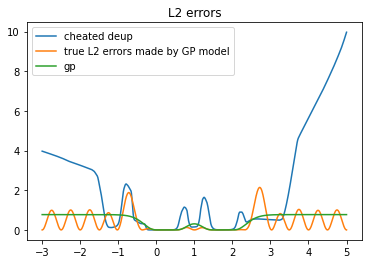

Average gap squared (lower is better): 
DEUP:  9.972136497497559
GPvar:  0.19806215167045593


In [501]:
gp_L2_errors = (gp_predictions.mean - y_test.squeeze()).pow(2).detach()
plt.title('L2 errors')
plt.plot(x_test, model._uncertainty(x=x_test).detach(), label='cheated deup')
plt.plot(x_test, gp_L2_errors, label='true L2 errors made by GP model')
plt.plot(x_test, gp_predictions.stddev.detach().pow(2), label='gp')
# plt.ylim(-2, 20)
plt.legend()
plt.show()
print('Average gap squared (lower is better): ')
print('DEUP: ', (model._uncertainty(x=x_test).detach() - gp_L2_errors).pow(2).mean().item())
print('GPvar: ', (gp_predictions.stddev.detach().pow(2) - gp_L2_errors).pow(2).mean().item())

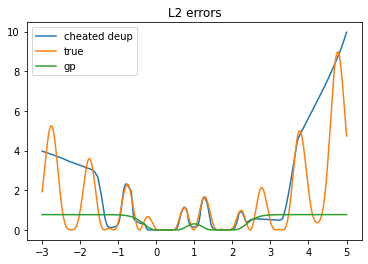

Average gap squared (lower is better): 
DEUP:  3.306149482727051
GPvar:  4.940675735473633


In [497]:
plt.title('L2 errors')
plt.plot(x_test, model._uncertainty(x=x_test).detach(), label='cheated deup')
plt.plot(x_test, true_L2_errors, label='true')
plt.plot(x_test, gp_predictions.stddev.detach().pow(2), label='gp')
# plt.ylim(-2, 20)
plt.legend()
plt.show()
print('Average gap squared (lower is better): ')
print('DEUP: ', (model._uncertainty(x=x_test).detach() - true_L2_errors).pow(2).mean().item())
print('GPvar: ', (gp_predictions.stddev.detach().pow(2) - true_L2_errors).pow(2).mean().item())

In [495]:
model._uncertainty(x=x_test).detach().pow(2)

tensor([[15.7711],
        [15.7292],
        [15.6873],
        ...,
        [97.4675],
        [98.4230],
        [99.3831]])